# Imports

In [1]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
from autograd.misc.optimizers import adam
import os

# Function Definitions

In [2]:
# Weight initialisation
def init_random_params(scale, layer_sizes, rs=npr.RandomState(42)):
    return [(rs.randn(insize, outsize) * scale,   # weight matrix
             rs.randn(outsize) * scale)           # bias vector
            for insize, outsize in zip(layer_sizes[:-1], layer_sizes[1:])]

# Activation function
def tanh(x):
    return (2 / (1.0 + np.exp(-2*x))) - 1
    #return np.log(1+np.exp(x))
    #return np.exp(x)

# Returns the NN output AFTER enforcing the boundary condition. This is the wavefunction (wf).
def psi(nnparams, inputs):
    origInput = inputs
    xTilde = (origInput - x0) / (x1 - x0)
    
    for W, b in nnparams:
        outputs = np.dot(inputs, W) + b
        inputs = tanh(outputs)    
        
    # Enforcing the boundary conditions
    return (1-xTilde)*psi0 + xTilde*psi1 + (1-np.exp(xTilde * (1 - xTilde))) * outputs


dpsi = elementwise_grad(psi, 1) # Function for returning first derivative of wf (not used explicitly)
ddpsi = elementwise_grad(dpsi, 1) # Second derivative of wf. 

In [3]:
objCase = 8

def energyStr (paramsE) :
    Efloat = float(paramsE)
    Eint = int(np.floor(Efloat))

    if Efloat - Eint == 0 :
        return "E" + str(int(np.floor(Efloat)))
    else :
        Estr = str(Efloat)
        return "E" + str(int(np.floor(Efloat))) + "p" + Estr[Estr.find('.')+1:]

# Objective function
def objective(params, step):
    nnparams = params['nn']
    E = params['E']        
    
    wf = psi(nnparams,x)    # Wavefunction
    diffeq = -0.5 * ddpsi(nnparams, x)  - E*wf  # Schrodinger equation in functional form
    y2 = wf**2   # Probability density function
    
    # This is a numerical trapezoid integration
    prob = np.sum((y2[1:] + y2[0:-1]) / 2 * (x[1:] - x[0:-1]))
    
    # First term is the MSE, second term is used to constrain the probability to 1.
    if objCase == 1 :
        return np.mean(diffeq**2) + (1 - prob)**2 + 4/prob + (prob**4)
    elif objCase == 2 :
        return np.mean(diffeq**2) + (1 - prob)**2 + 10/prob + (10/4)*(prob**4)
    elif objCase == 3 :
        return np.mean(diffeq**2) + 100*(1 - prob)**2 + 1000/prob + (1000/4)*(prob**4)
    elif objCase == 4 :
        return np.mean(diffeq**2) + (1-prob)**2 + (10/prob + 10*prob) + ((1/4)/prob**2 + (1/4)*prob**2)
    elif objCase == 5 :
        return np.mean(diffeq**2) + (1-prob)**2 + (20/prob + 2*prob) + (1/prob**2 + 10*prob**2)
    elif objCase == 6 :
        return np.mean(diffeq**2) + (1-prob)**2 + (120/prob + 120*prob) + (30/prob**2 + 30*prob**2) + (5/prob**3 + 5*prob**3)
    elif objCase == 7 :
        return np.mean(diffeq**2) + (1-prob)**2 + (120/prob + 120*prob) + (30/prob**2 + 30*prob**2) + (5/prob**3 + 5*prob**3) + (5/(8*prob**4) + (5/8)*prob**4)
    elif objCase == 8 :
        return np.mean(diffeq**2) + (1-prob)**2 + (10/prob + 10*prob) + (5/prob**2 + 5*prob**2) + ((5/6)/prob**3 + (5/6)*prob**3) + (5/(48*prob**4) + (5/48)*prob**4)

iterList = []
diffeqList = []
probList = []
lossList = []
EList = []
# Helper function for callback. Prints the following -
# 1. Iteration no.
# 2. MSE term
# 3. Probability integral
# 4. Loss
# 5. Eigen-energy 
def objectiveDebug (params, step) :
    nnparams = params['nn']
    E = params['E']   
    
    wf = psi(nnparams,x)    # Wavefunction
    diffeq = -0.5 * ddpsi(nnparams, x)  - E*wf  # Schrodinger equation in functional form
    y2 = wf**2   # Probability density function
    mean = np.mean(diffeq**2)  # MSE

    # This is a numerical trapezoid integration
    prob = np.sum((y2[1:] + y2[0:-1]) / 2 * (x[1:] - x[0:-1]))
    
    if objCase == 1 :
        loss = mean + (1-prob)**2 + 4/prob + (prob**4)
    elif objCase == 2 :
        loss = mean + (1 - prob)**2 + 10/prob + (10/4)*(prob**4)
    elif objCase == 3 :
        loss = mean + 100*(1-prob)**2 + 1000/prob + (1000/4)*(prob**4)
    elif objCase == 4 :
        loss = mean + (1-prob)**2 + (10/prob + 10*prob) + ((1/4)/prob**2 + (1/4)*prob**2)
    elif objCase == 5 :
        loss = mean + (1-prob)**2 + (20/prob + 2*prob) + (1/prob**2 + 10*prob**2)
    elif objCase == 6 :
        loss = mean + (1-prob)**2 + (120/prob + 120*prob) + (30/prob**2 + 30*prob**2) + (5/prob**3 + 5*prob**3)
    elif objCase == 7 :
        loss = mean + (1-prob)**2 + (120/prob + 120*prob) + (30/prob**2 + 30*prob**2) + (5/prob**3 + 5*prob**3) + (5/(8*prob**4) + (5/8)*prob**4)
    elif objCase == 8 :
        loss = mean + (1-prob)**2 + (10/prob + 10*prob) + (5/prob**2 + 5*prob**2) + ((5/6)/prob**3 + (5/6)*prob**3) + (5/(48*prob**4) + (5/48)*prob**4)
    
    iterList.append (step)
    diffeqList.append (mean)
    probList.append (prob)
    lossList.append (loss)
    EList.append (float(params['E']))
    
    print ("Iteration " + str(step) + " diffeq = " + str(mean) + " prob = " + str(prob))
    print ("loss = " + str(loss) + " E = " + str(params['E']))
    print ("---------------------------------")
    

# Callback function.
def callback(params, step, g):
    if step % 100 == 0:
        objectiveDebug (params, step)

# Initialisation

In [4]:
psi0 = 0 # Value of first boundary
psi1 = 0 # Value of second boundary
L = 1 # Length of the well
n = 3 # Energy level to be found
scale = 2 # Scale for initialisation
divs = 200 # divisions of the input space

x0 = 0  # Position of first boundary
x1 = L  # Position of second boundary

In [5]:
# Initialising the weights. They usually fall between 0 and 1 which causes the initial wavefunction
# to have a small probability integral over the range. Hence, I've put a scale factor of 2 that changes gives it
# a random (but sizeable) shape so that over the epochs, the probability integral converges to 1.
nnparams = init_random_params(scale/(x1-x0), layer_sizes=[1, 32, 32, 1])

# The ground state energy of the particle in a box is (pi^2)/2 = 4.9348. I've initialised E to 4.0
# so that it converges to the eigenenergy quickly.
initE = 75.0
params = {'nn': nnparams, 'E': initE}

# Input space
x = np.linspace(x0, x1, divs)[:, None]

# Setting up the name for saving files
name = "n" + str(n)+ "L" + str(L) + energyStr(params['E'])

# Optimization

In [6]:
params = adam(grad(objective), params,
              step_size=0.001, num_iters=10001, callback=callback) 

Iteration 0 diffeq = 16820.673147997113 prob = 3.5325060280642115
loss = 16981.01019563101 E = 75.0
---------------------------------
Iteration 100 diffeq = 252.84355431406559 prob = 0.40439933010097295
loss = 329.91500234763726 E = 74.9739518358902
---------------------------------
Iteration 200 diffeq = 81.426635205877 prob = 0.4562384630008146
loss = 144.5272761884737 E = 74.97210437617173
---------------------------------
Iteration 300 diffeq = 49.66999098312193 prob = 0.45943480456414615
loss = 112.08192834079165 E = 74.97593387487888
---------------------------------
Iteration 400 diffeq = 32.51727244572913 prob = 0.4505759197632463
loss = 96.8798364844362 E = 74.98142733996156
---------------------------------
Iteration 500 diffeq = 27.29036597979507 prob = 0.4578287031281074
loss = 90.04628348456471 E = 74.98822096720065
---------------------------------
Iteration 600 diffeq = 25.541665739117825 prob = 0.47048283399294555
loss = 85.69629362115428 E = 74.996380315952
-----------

Iteration 5600 diffeq = 2.4307601781215094 prob = 0.9603910859144966
loss = 34.37134278847984 E = 77.39255235029144
---------------------------------
Iteration 5700 diffeq = 2.235571669521271 prob = 0.9624720991965685
loss = 34.16931676070871 E = 77.45879361937271
---------------------------------
Iteration 5800 diffeq = 2.0513378595442915 prob = 0.9645844419989985
loss = 33.97854148385603 E = 77.52418031614287
---------------------------------
Iteration 5900 diffeq = 1.8771219156206598 prob = 0.9666943938035609
loss = 33.79819009580607 E = 77.58866939923176
---------------------------------
Iteration 6000 diffeq = 1.7127694024347233 prob = 0.9686953041865364
loss = 33.628384849553186 E = 77.65221120761035
---------------------------------
Iteration 6100 diffeq = 1.5579700924180537 prob = 0.9706813043039433
loss = 33.468523160087805 E = 77.714764329009
---------------------------------
Iteration 6200 diffeq = 1.4127348311971268 prob = 0.9726419192722868
loss = 33.31862987119251 E = 77.

# Plots

In [7]:
replot = 1
if replot == 1 :
    params['E'] = initE
    n = 4
    L = 1
    name = "n" + str(n)+ "L" + str(L) + energyStr(params['E'])

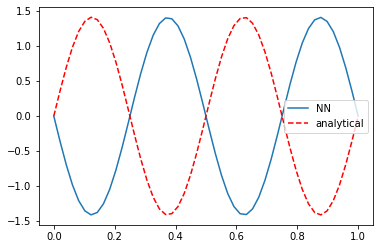

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
x = np.linspace(x0, x1)[:, None]
y = psi(params['nn'], x)

plt.plot(x, y, label='NN')  # Plotting the NN output
plt.plot(x, np.sqrt(2/L) * np.sin(n*np.pi * (x-x0)/L), 'r--', label='analytical')  # Plotting the actual wavefuncion
plt.legend()
plt.savefig (name + "_plot.png")

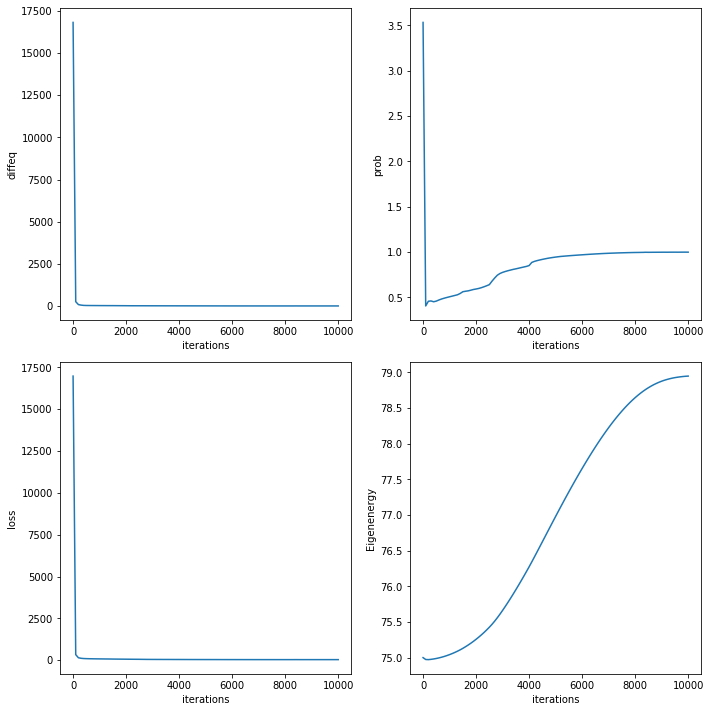

In [9]:
fig = plt.figure (figsize=(10,10))
plt.clf ()

plt.subplot (2 , 2 , 1)
plt.plot (iterList, diffeqList)
plt.xlabel ('iterations')
plt.ylabel ('diffeq')

plt.subplot (2, 2, 2)
plt.plot (iterList, probList)
plt.xlabel ('iterations')
plt.ylabel ('prob')

plt.subplot (2, 2, 3)
plt.plot (iterList, lossList)
plt.xlabel ('iterations')
plt.ylabel ('loss')

plt.subplot (2, 2, 4)
plt.plot (iterList, EList)
plt.ylabel ('Eigenenergy')
plt.xlabel ('iterations')
plt.tight_layout()

plt.savefig (name + "_diagAll.png")

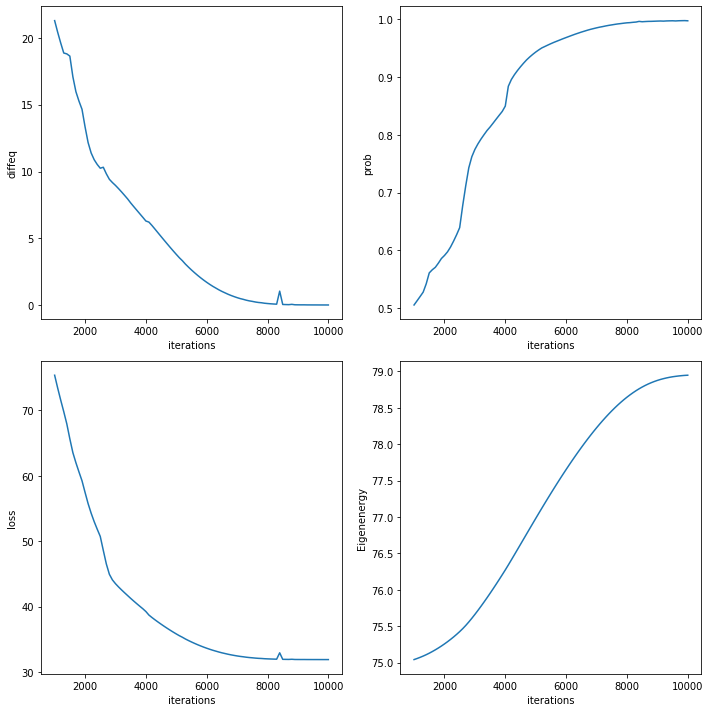

In [10]:
fig = plt.figure (figsize=(10,10))
trunc = 10

plt.subplot (2 , 2 , 1)
plt.plot (iterList[trunc:], diffeqList[trunc:])
plt.xlabel ('iterations')
plt.ylabel ('diffeq')

plt.subplot (2, 2, 2)
plt.plot (iterList[trunc:], probList[trunc:])
plt.xlabel ('iterations')
plt.ylabel ('prob')

plt.subplot (2, 2, 3)
plt.plot (iterList[trunc:], lossList[trunc:])
plt.xlabel ('iterations')
plt.ylabel ('loss')

plt.subplot (2, 2, 4)
plt.plot (iterList[trunc:], EList[trunc:])
plt.ylabel ('Eigenenergy')
plt.xlabel ('iterations')
plt.tight_layout()

plt.savefig (name + "_diagTrunc" + str(trunc) + ".png")

# Write to file

In [11]:
outfile = open(name + "_info.txt" , "w")

fstr = "diffeq = " + str(round(diffeqList[-1],8)) + "\nprob = " + str(round(probList[-1],8)) + "\nloss = " + str(round(lossList[-1],8)) + "\neigE = " + str(round(EList[-1],8))
    
outfile.write (fstr)
outfile.close ()

In [12]:
print ("\diffeq = " + str(round(diffeqList[-1],8)) + ", \prob = " + str(round(probList[-1],8)) + 
       ", \loss = " + str(round(lossList[-1],8)) + ", \eigE = " + str(round(EList[-1],8)))

\diffeq = 0.01632374, \prob = 0.99770152, \loss = 31.89153642, \eigE = 78.94750435
